# Test

In [1]:
import nonlinear_dce
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/opt/anaconda3/envs/admg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

dummy_model = DummyModel()

dagma = nonlinear_dce.DagmaDCE(model=dummy_model, use_mle_loss=True)
dims = [5,7,1]
dagma_mlp = nonlinear_dce.DagmaMLP_DCE(dims=dims)
n, d = 100, dims[0]
target = torch.randn(n, d)
output = target + 0.1 * torch.randn(n, d)

A = torch.randn(d, d)
Sigma = A @ A.T + 1e-3 * torch.eye(d)

## Forward

In [3]:
dagma_mlp.forward(target).shape

torch.Size([100, 5])

## MLE loss

In [4]:
loss_value = dagma.mle_loss(output=output, target=target, Sigma=Sigma)
print("MLE loss:", loss_value.item())

MLE loss: 1.5147263100335793


In [5]:
tmp = 0
diff = target - output
for i in range(0,n):
    tmp += diff[i, :]@ torch.inverse(Sigma)@diff[i, :].unsqueeze(1)

logdet = torch.logdet(Sigma)
loss_value2 = tmp/n + logdet
print("MLE loss:", loss_value2.item())

MLE loss: 1.5147263100335793


## Ancestral loss

In [6]:
Sigma = torch.tensor([[0.5, 0.3],   
                [0.3, 1.5]])
Wii = torch.diag(torch.diag(Sigma))
W2 = Sigma - Wii

W1 = torch.tensor([[0.0, 1.0],   
                [0.0, 0.0]])
ancestrality =dagma_mlp.ancestrality_loss(W1, W2)
print("ancestrality_loss", ancestrality)

ancestrality_loss tensor(0.0900)


In [7]:
Sigma = torch.tensor([[0.5, 0.8],   
                [0.8, 1.5]])
Wii = torch.diag(torch.diag(Sigma))
W2 = Sigma - Wii

W1 = torch.tensor([[0.0, 1.0],   
                [0.0, 0.0]])
ancestrality =dagma_mlp.ancestrality_loss(W1, W2)
print("ancestrality_loss", ancestrality)

ancestrality_loss tensor(0.6400)


## h_func

In [8]:
W1 = torch.rand(d, d)   # values in [0,1)
W2 = torch.rand(d, d)
h_value =dagma_mlp.h_func(W1, W2)
print("h_value:", h_value.item())

h_value: 0.9076880854378115


## Log Cholesky

In [9]:
A = torch.randn(d, d)             
Sigma = A @ A.T + 1e-3 * torch.eye(d)
print("Sigma: ", Sigma)

Sigma:  tensor([[ 1.6782, -2.0258,  2.5619,  0.0457,  0.9742],
        [-2.0258,  3.4804, -1.9999,  0.4295, -1.0969],
        [ 2.5619, -1.9999,  8.5649, -0.1418,  0.9281],
        [ 0.0457,  0.4295, -0.1418,  1.4832,  1.8172],
        [ 0.9742, -1.0969,  0.9281,  1.8172,  3.7486]])


In [10]:
M = nonlinear_dce.reverse_SPDLogCholesky(Sigma)
print("M: ", M)

M:  tensor([[ 0.2588,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.5638,  0.0171,  0.0000,  0.0000,  0.0000],
        [ 1.9776,  1.0743,  0.6264,  0.0000,  0.0000],
        [ 0.0353,  0.4764, -0.3866,  0.0501,  0.0000],
        [ 0.7520,  0.0778, -0.3436,  1.5415, -0.1909]])


In [11]:
Sigma = nonlinear_dce.SPDLogCholesky(M)
print("Sigma: ", Sigma)

Sigma:  tensor([[ 1.6782, -2.0258,  2.5619,  0.0457,  0.9742],
        [-2.0258,  3.4804, -1.9999,  0.4295, -1.0969],
        [ 2.5619, -1.9999,  8.5649, -0.1418,  0.9281],
        [ 0.0457,  0.4295, -0.1418,  1.4832,  1.8172],
        [ 0.9742, -1.0969,  0.9281,  1.8172,  3.7486]])


## Simulation

In [17]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [18]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)


  1%|          | 149/29000 [00:00<01:14, 389.18it/s]

Sigma:  tensor([[0.9605, 0.0195],
        [0.0195, 1.0411]], grad_fn=<MmBackward0>)
obj:  tensor(29.5747, grad_fn=<AddBackward0>)
mle loss:  tensor(29.5731, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


  1%|          | 277/29000 [00:00<01:09, 412.39it/s]

Sigma:  tensor([[0.9214, 0.0379],
        [0.0379, 1.0842]], grad_fn=<MmBackward0>)
obj:  tensor(27.4813, grad_fn=<AddBackward0>)
mle loss:  tensor(27.4776, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


  1%|          | 361/29000 [00:00<01:10, 407.63it/s]

Sigma:  tensor([[0.8827, 0.0547],
        [0.0547, 1.1288]], grad_fn=<MmBackward0>)
obj:  tensor(25.4552, grad_fn=<AddBackward0>)
mle loss:  tensor(25.4487, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


  2%|▏         | 445/29000 [00:01<01:08, 414.43it/s]

Sigma:  tensor([[0.8448, 0.0700],
        [0.0700, 1.1743]], grad_fn=<MmBackward0>)
obj:  tensor(23.4984, grad_fn=<AddBackward0>)
mle loss:  tensor(23.4884, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)


  2%|▏         | 574/29000 [00:01<01:07, 421.49it/s]

Sigma:  tensor([[0.8079, 0.0836],
        [0.0836, 1.2203]], grad_fn=<MmBackward0>)
obj:  tensor(21.6331, grad_fn=<AddBackward0>)
mle loss:  tensor(21.6191, grad_fn=<AddBackward0>)
h_val:  tensor(0.0064, grad_fn=<AddBackward0>)


  2%|▏         | 660/29000 [00:01<01:07, 417.94it/s]

Sigma:  tensor([[0.7723, 0.0956],
        [0.0956, 1.2665]], grad_fn=<MmBackward0>)
obj:  tensor(19.8790, grad_fn=<AddBackward0>)
mle loss:  tensor(19.8604, grad_fn=<AddBackward0>)
h_val:  tensor(0.0095, grad_fn=<AddBackward0>)


  3%|▎         | 745/29000 [00:01<01:07, 417.38it/s]

Sigma:  tensor([[0.7384, 0.1064],
        [0.1064, 1.3126]], grad_fn=<MmBackward0>)
obj:  tensor(18.2462, grad_fn=<AddBackward0>)
mle loss:  tensor(18.2227, grad_fn=<AddBackward0>)
h_val:  tensor(0.0131, grad_fn=<AddBackward0>)


  3%|▎         | 875/29000 [00:02<01:06, 420.76it/s]

Sigma:  tensor([[0.7063, 0.1164],
        [0.1164, 1.3586]], grad_fn=<MmBackward0>)
obj:  tensor(16.7405, grad_fn=<AddBackward0>)
mle loss:  tensor(16.7117, grad_fn=<AddBackward0>)
h_val:  tensor(0.0173, grad_fn=<AddBackward0>)


  3%|▎         | 961/29000 [00:02<01:06, 419.74it/s]

Sigma:  tensor([[0.6759, 0.1258],
        [0.1258, 1.4044]], grad_fn=<MmBackward0>)
obj:  tensor(15.3625, grad_fn=<AddBackward0>)
mle loss:  tensor(15.3277, grad_fn=<AddBackward0>)
h_val:  tensor(0.0222, grad_fn=<AddBackward0>)


  4%|▎         | 1049/29000 [00:02<01:05, 425.25it/s]

Sigma:  tensor([[0.6471, 0.1350],
        [0.1350, 1.4499]], grad_fn=<MmBackward0>)
obj:  tensor(14.1085, grad_fn=<AddBackward0>)
mle loss:  tensor(14.0672, grad_fn=<AddBackward0>)
h_val:  tensor(0.0277, grad_fn=<AddBackward0>)


  4%|▍         | 1181/29000 [00:02<01:04, 430.46it/s]

Sigma:  tensor([[0.6200, 0.1440],
        [0.1440, 1.4952]], grad_fn=<MmBackward0>)
obj:  tensor(12.9714, grad_fn=<AddBackward0>)
mle loss:  tensor(12.9230, grad_fn=<AddBackward0>)
h_val:  tensor(0.0339, grad_fn=<AddBackward0>)


  4%|▍         | 1270/29000 [00:03<01:04, 432.74it/s]

Sigma:  tensor([[0.5944, 0.1529],
        [0.1529, 1.5403]], grad_fn=<MmBackward0>)
obj:  tensor(11.9420, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8858, grad_fn=<AddBackward0>)
h_val:  tensor(0.0408, grad_fn=<AddBackward0>)


  5%|▍         | 1357/29000 [00:03<01:04, 426.91it/s]

Sigma:  tensor([[0.5701, 0.1616],
        [0.1616, 1.5852]], grad_fn=<MmBackward0>)
obj:  tensor(11.0103, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9456, grad_fn=<AddBackward0>)
h_val:  tensor(0.0484, grad_fn=<AddBackward0>)


  5%|▍         | 1443/29000 [00:03<01:05, 422.04it/s]

Sigma:  tensor([[0.5470, 0.1700],
        [0.1700, 1.6299]], grad_fn=<MmBackward0>)
obj:  tensor(10.1663, grad_fn=<AddBackward0>)
mle loss:  tensor(10.0925, grad_fn=<AddBackward0>)
h_val:  tensor(0.0566, grad_fn=<AddBackward0>)


  5%|▌         | 1574/29000 [00:03<01:04, 428.06it/s]

Sigma:  tensor([[0.5250, 0.1780],
        [0.1780, 1.6742]], grad_fn=<MmBackward0>)
obj:  tensor(9.4007, grad_fn=<AddBackward0>)
mle loss:  tensor(9.3173, grad_fn=<AddBackward0>)
h_val:  tensor(0.0653, grad_fn=<AddBackward0>)


  6%|▌         | 1660/29000 [00:03<01:04, 424.61it/s]

Sigma:  tensor([[0.5040, 0.1856],
        [0.1856, 1.7182]], grad_fn=<MmBackward0>)
obj:  tensor(8.7053, grad_fn=<AddBackward0>)
mle loss:  tensor(8.6117, grad_fn=<AddBackward0>)
h_val:  tensor(0.0746, grad_fn=<AddBackward0>)


  6%|▌         | 1746/29000 [00:04<01:04, 423.83it/s]

Sigma:  tensor([[0.4839, 0.1927],
        [0.1927, 1.7619]], grad_fn=<MmBackward0>)
obj:  tensor(8.0723, grad_fn=<AddBackward0>)
mle loss:  tensor(7.9681, grad_fn=<AddBackward0>)
h_val:  tensor(0.0843, grad_fn=<AddBackward0>)


  6%|▋         | 1877/29000 [00:04<01:02, 431.67it/s]

Sigma:  tensor([[0.4646, 0.1994],
        [0.1994, 1.8052]], grad_fn=<MmBackward0>)
obj:  tensor(7.4952, grad_fn=<AddBackward0>)
mle loss:  tensor(7.3799, grad_fn=<AddBackward0>)
h_val:  tensor(0.0946, grad_fn=<AddBackward0>)


  7%|▋         | 1964/29000 [00:04<01:03, 426.34it/s]

Sigma:  tensor([[0.4462, 0.2055],
        [0.2055, 1.8481]], grad_fn=<MmBackward0>)
obj:  tensor(6.9678, grad_fn=<AddBackward0>)
mle loss:  tensor(6.8410, grad_fn=<AddBackward0>)
h_val:  tensor(0.1053, grad_fn=<AddBackward0>)


  7%|▋         | 2050/29000 [00:04<01:03, 422.97it/s]

Sigma:  tensor([[0.4285, 0.2112],
        [0.2112, 1.8906]], grad_fn=<MmBackward0>)
obj:  tensor(6.4851, grad_fn=<AddBackward0>)
mle loss:  tensor(6.3463, grad_fn=<AddBackward0>)
h_val:  tensor(0.1165, grad_fn=<AddBackward0>)


  8%|▊         | 2180/29000 [00:05<01:03, 421.50it/s]

Sigma:  tensor([[0.4116, 0.2165],
        [0.2165, 1.9327]], grad_fn=<MmBackward0>)
obj:  tensor(6.0424, grad_fn=<AddBackward0>)
mle loss:  tensor(5.8911, grad_fn=<AddBackward0>)
h_val:  tensor(0.1281, grad_fn=<AddBackward0>)


  8%|▊         | 2223/29000 [00:05<01:03, 418.89it/s]

Sigma:  tensor([[0.3953, 0.2213],
        [0.2213, 1.9744]], grad_fn=<MmBackward0>)
obj:  tensor(5.6357, grad_fn=<AddBackward0>)
mle loss:  tensor(5.4716, grad_fn=<AddBackward0>)
h_val:  tensor(0.1402, grad_fn=<AddBackward0>)


  8%|▊         | 2352/29000 [00:05<01:15, 353.37it/s]

Sigma:  tensor([[0.3798, 0.2257],
        [0.2257, 2.0156]], grad_fn=<MmBackward0>)
obj:  tensor(5.2614, grad_fn=<AddBackward0>)
mle loss:  tensor(5.0840, grad_fn=<AddBackward0>)
h_val:  tensor(0.1526, grad_fn=<AddBackward0>)


  9%|▊         | 2481/29000 [00:06<01:06, 398.99it/s]

Sigma:  tensor([[0.3648, 0.2296],
        [0.2296, 2.0564]], grad_fn=<MmBackward0>)
obj:  tensor(4.9163, grad_fn=<AddBackward0>)
mle loss:  tensor(4.7253, grad_fn=<AddBackward0>)
h_val:  tensor(0.1655, grad_fn=<AddBackward0>)


  9%|▉         | 2566/29000 [00:06<01:04, 408.75it/s]

Sigma:  tensor([[0.3504, 0.2332],
        [0.2332, 2.0967]], grad_fn=<MmBackward0>)
obj:  tensor(4.5977, grad_fn=<AddBackward0>)
mle loss:  tensor(4.3927, grad_fn=<AddBackward0>)
h_val:  tensor(0.1787, grad_fn=<AddBackward0>)


  9%|▉         | 2653/29000 [00:06<01:02, 419.99it/s]

Sigma:  tensor([[0.3367, 0.2365],
        [0.2365, 2.1365]], grad_fn=<MmBackward0>)
obj:  tensor(4.3031, grad_fn=<AddBackward0>)
mle loss:  tensor(4.0838, grad_fn=<AddBackward0>)
h_val:  tensor(0.1924, grad_fn=<AddBackward0>)


 10%|▉         | 2785/29000 [00:06<01:00, 430.72it/s]

Sigma:  tensor([[0.3234, 0.2394],
        [0.2394, 2.1759]], grad_fn=<MmBackward0>)
obj:  tensor(4.0304, grad_fn=<AddBackward0>)
mle loss:  tensor(3.7964, grad_fn=<AddBackward0>)
h_val:  tensor(0.2063, grad_fn=<AddBackward0>)


 10%|▉         | 2873/29000 [00:06<01:01, 427.08it/s]

Sigma:  tensor([[0.3107, 0.2420],
        [0.2420, 2.2147]], grad_fn=<MmBackward0>)
obj:  tensor(3.7776, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5286, grad_fn=<AddBackward0>)
h_val:  tensor(0.2206, grad_fn=<AddBackward0>)


 10%|█         | 2959/29000 [00:07<01:01, 424.32it/s]

Sigma:  tensor([[0.2985, 0.2443],
        [0.2443, 2.2530]], grad_fn=<MmBackward0>)
obj:  tensor(3.5429, grad_fn=<AddBackward0>)
mle loss:  tensor(3.2786, grad_fn=<AddBackward0>)
h_val:  tensor(0.2352, grad_fn=<AddBackward0>)


 10%|█         | 3045/29000 [00:07<01:01, 419.48it/s]

Sigma:  tensor([[0.2868, 0.2463],
        [0.2463, 2.2908]], grad_fn=<MmBackward0>)
obj:  tensor(3.3247, grad_fn=<AddBackward0>)
mle loss:  tensor(3.0449, grad_fn=<AddBackward0>)
h_val:  tensor(0.2501, grad_fn=<AddBackward0>)


 11%|█         | 3175/29000 [00:07<01:00, 425.44it/s]

Sigma:  tensor([[0.2756, 0.2480],
        [0.2480, 2.3280]], grad_fn=<MmBackward0>)
obj:  tensor(3.1217, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8262, grad_fn=<AddBackward0>)
h_val:  tensor(0.2652, grad_fn=<AddBackward0>)


 11%|█         | 3261/29000 [00:07<01:01, 420.62it/s]

Sigma:  tensor([[0.2648, 0.2495],
        [0.2495, 2.3647]], grad_fn=<MmBackward0>)
obj:  tensor(2.9326, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6211, grad_fn=<AddBackward0>)
h_val:  tensor(0.2805, grad_fn=<AddBackward0>)


 12%|█▏        | 3349/29000 [00:08<01:00, 426.69it/s]

Sigma:  tensor([[0.2545, 0.2508],
        [0.2508, 2.4009]], grad_fn=<MmBackward0>)
obj:  tensor(2.7562, grad_fn=<AddBackward0>)
mle loss:  tensor(2.4285, grad_fn=<AddBackward0>)
h_val:  tensor(0.2960, grad_fn=<AddBackward0>)


 12%|█▏        | 3481/29000 [00:08<01:00, 423.48it/s]

Sigma:  tensor([[0.2445, 0.2519],
        [0.2519, 2.4365]], grad_fn=<MmBackward0>)
obj:  tensor(2.5914, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2475, grad_fn=<AddBackward0>)
h_val:  tensor(0.3116, grad_fn=<AddBackward0>)


 12%|█▏        | 3567/29000 [00:08<01:00, 420.60it/s]

Sigma:  tensor([[0.2350, 0.2527],
        [0.2527, 2.4714]], grad_fn=<MmBackward0>)
obj:  tensor(2.4373, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0771, grad_fn=<AddBackward0>)
h_val:  tensor(0.3272, grad_fn=<AddBackward0>)


 13%|█▎        | 3654/29000 [00:08<00:59, 423.59it/s]

Sigma:  tensor([[0.2258, 0.2534],
        [0.2534, 2.5058]], grad_fn=<MmBackward0>)
obj:  tensor(2.2930, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9164, grad_fn=<AddBackward0>)
h_val:  tensor(0.3429, grad_fn=<AddBackward0>)


 13%|█▎        | 3784/29000 [00:09<00:59, 425.33it/s]

Sigma:  tensor([[0.2170, 0.2539],
        [0.2539, 2.5396]], grad_fn=<MmBackward0>)
obj:  tensor(2.1576, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7648, grad_fn=<AddBackward0>)
h_val:  tensor(0.3585, grad_fn=<AddBackward0>)


 13%|█▎        | 3872/29000 [00:09<00:58, 428.07it/s]

Sigma:  tensor([[0.2086, 0.2543],
        [0.2543, 2.5728]], grad_fn=<MmBackward0>)
obj:  tensor(2.0303, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6214, grad_fn=<AddBackward0>)
h_val:  tensor(0.3740, grad_fn=<AddBackward0>)


 14%|█▎        | 3959/29000 [00:09<00:58, 427.89it/s]

Sigma:  tensor([[0.2005, 0.2545],
        [0.2545, 2.6054]], grad_fn=<MmBackward0>)
obj:  tensor(1.9105, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4856, grad_fn=<AddBackward0>)
h_val:  tensor(0.3892, grad_fn=<AddBackward0>)


 14%|█▍        | 4045/29000 [00:09<00:59, 422.61it/s]

Sigma:  tensor([[0.1927, 0.2545],
        [0.2545, 2.6373]], grad_fn=<MmBackward0>)
obj:  tensor(1.7973, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3569, grad_fn=<AddBackward0>)
h_val:  tensor(0.4042, grad_fn=<AddBackward0>)


 14%|█▍        | 4176/29000 [00:10<00:57, 429.29it/s]

Sigma:  tensor([[0.1852, 0.2545],
        [0.2545, 2.6685]], grad_fn=<MmBackward0>)
obj:  tensor(1.6903, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2346, grad_fn=<AddBackward0>)
h_val:  tensor(0.4187, grad_fn=<AddBackward0>)


 15%|█▍        | 4262/29000 [00:10<01:03, 389.35it/s]

Sigma:  tensor([[0.1780, 0.2544],
        [0.2544, 2.6991]], grad_fn=<MmBackward0>)
obj:  tensor(1.5887, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1184, grad_fn=<AddBackward0>)
h_val:  tensor(0.4327, grad_fn=<AddBackward0>)


 15%|█▍        | 4346/29000 [00:10<01:01, 401.25it/s]

Sigma:  tensor([[0.1711, 0.2541],
        [0.2541, 2.7289]], grad_fn=<MmBackward0>)
obj:  tensor(1.4919, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0076, grad_fn=<AddBackward0>)
h_val:  tensor(0.4460, grad_fn=<AddBackward0>)


 15%|█▌        | 4478/29000 [00:10<00:57, 422.94it/s]

Sigma:  tensor([[0.1645, 0.2538],
        [0.2538, 2.7581]], grad_fn=<MmBackward0>)
obj:  tensor(1.3993, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9018, grad_fn=<AddBackward0>)
h_val:  tensor(0.4586, grad_fn=<AddBackward0>)


 16%|█▌        | 4564/29000 [00:11<00:57, 422.61it/s]

Sigma:  tensor([[0.1581, 0.2533],
        [0.2533, 2.7865]], grad_fn=<MmBackward0>)
obj:  tensor(1.3105, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8006, grad_fn=<AddBackward0>)
h_val:  tensor(0.4702, grad_fn=<AddBackward0>)


 16%|█▌        | 4651/29000 [00:11<00:57, 424.79it/s]

Sigma:  tensor([[0.1520, 0.2528],
        [0.2528, 2.8141]], grad_fn=<MmBackward0>)
obj:  tensor(1.2248, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7036, grad_fn=<AddBackward0>)
h_val:  tensor(0.4808, grad_fn=<AddBackward0>)


 16%|█▋        | 4782/29000 [00:11<00:56, 426.95it/s]

Sigma:  tensor([[0.1462, 0.2523],
        [0.2523, 2.8410]], grad_fn=<MmBackward0>)
obj:  tensor(1.1419, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6104, grad_fn=<AddBackward0>)
h_val:  tensor(0.4903, grad_fn=<AddBackward0>)


 17%|█▋        | 4869/29000 [00:11<00:56, 425.66it/s]

Sigma:  tensor([[0.1405, 0.2517],
        [0.2517, 2.8670]], grad_fn=<MmBackward0>)
obj:  tensor(1.0612, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5206, grad_fn=<AddBackward0>)
h_val:  tensor(0.4987, grad_fn=<AddBackward0>)


 17%|█▋        | 4956/29000 [00:11<00:56, 425.06it/s]

Sigma:  tensor([[0.1351, 0.2510],
        [0.2510, 2.8922]], grad_fn=<MmBackward0>)
obj:  tensor(0.9824, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4339, grad_fn=<AddBackward0>)
h_val:  tensor(0.5057, grad_fn=<AddBackward0>)


 17%|█▋        | 5042/29000 [00:12<00:56, 422.58it/s]

Sigma:  tensor([[0.1299, 0.2503],
        [0.2503, 2.9165]], grad_fn=<MmBackward0>)
obj:  tensor(0.9051, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3501, grad_fn=<AddBackward0>)
h_val:  tensor(0.5114, grad_fn=<AddBackward0>)


 18%|█▊        | 5173/29000 [00:12<00:55, 426.74it/s]

Sigma:  tensor([[0.1249, 0.2495],
        [0.2495, 2.9399]], grad_fn=<MmBackward0>)
obj:  tensor(0.8288, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2688, grad_fn=<AddBackward0>)
h_val:  tensor(0.5156, grad_fn=<AddBackward0>)


 18%|█▊        | 5260/29000 [00:12<00:56, 421.67it/s]

Sigma:  tensor([[0.1201, 0.2487],
        [0.2487, 2.9623]], grad_fn=<MmBackward0>)
obj:  tensor(0.7535, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1898, grad_fn=<AddBackward0>)
h_val:  tensor(0.5184, grad_fn=<AddBackward0>)


 18%|█▊        | 5346/29000 [00:12<00:56, 419.41it/s]

Sigma:  tensor([[0.1155, 0.2479],
        [0.2479, 2.9837]], grad_fn=<MmBackward0>)
obj:  tensor(0.6788, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1127, grad_fn=<AddBackward0>)
h_val:  tensor(0.5198, grad_fn=<AddBackward0>)


 19%|█▉        | 5479/29000 [00:13<00:54, 429.61it/s]

Sigma:  tensor([[0.1111, 0.2470],
        [0.2470, 3.0040]], grad_fn=<MmBackward0>)
obj:  tensor(0.6047, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0374, grad_fn=<AddBackward0>)
h_val:  tensor(0.5202, grad_fn=<AddBackward0>)


 19%|█▉        | 5566/29000 [00:13<00:54, 428.84it/s]

Sigma:  tensor([[0.1069, 0.2462],
        [0.2462, 3.0231]], grad_fn=<MmBackward0>)
obj:  tensor(0.5311, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0366, grad_fn=<AddBackward0>)
h_val:  tensor(0.5196, grad_fn=<AddBackward0>)


 19%|█▉        | 5652/29000 [00:13<00:55, 424.22it/s]

Sigma:  tensor([[0.1028, 0.2453],
        [0.2453, 3.0410]], grad_fn=<MmBackward0>)
obj:  tensor(0.4580, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1095, grad_fn=<AddBackward0>)
h_val:  tensor(0.5183, grad_fn=<AddBackward0>)


 20%|█▉        | 5782/29000 [00:13<00:54, 426.17it/s]

Sigma:  tensor([[0.0989, 0.2444],
        [0.2444, 3.0576]], grad_fn=<MmBackward0>)
obj:  tensor(0.3854, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1814, grad_fn=<AddBackward0>)
h_val:  tensor(0.5166, grad_fn=<AddBackward0>)


 20%|██        | 5868/29000 [00:14<00:55, 420.08it/s]

Sigma:  tensor([[0.0951, 0.2435],
        [0.2435, 3.0728]], grad_fn=<MmBackward0>)
obj:  tensor(0.3132, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2527, grad_fn=<AddBackward0>)
h_val:  tensor(0.5145, grad_fn=<AddBackward0>)


 21%|██        | 5954/29000 [00:14<00:54, 419.13it/s]

Sigma:  tensor([[0.0915, 0.2425],
        [0.2425, 3.0866]], grad_fn=<MmBackward0>)
obj:  tensor(0.2415, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3235, grad_fn=<AddBackward0>)
h_val:  tensor(0.5124, grad_fn=<AddBackward0>)


 21%|██        | 6085/29000 [00:14<00:53, 431.56it/s]

Sigma:  tensor([[0.0880, 0.2416],
        [0.2416, 3.0987]], grad_fn=<MmBackward0>)
obj:  tensor(0.1701, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3940, grad_fn=<AddBackward0>)
h_val:  tensor(0.5104, grad_fn=<AddBackward0>)


 21%|██▏       | 6173/29000 [00:14<00:53, 429.70it/s]

Sigma:  tensor([[0.0846, 0.2406],
        [0.2406, 3.1091]], grad_fn=<MmBackward0>)
obj:  tensor(0.0991, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4643, grad_fn=<AddBackward0>)
h_val:  tensor(0.5084, grad_fn=<AddBackward0>)


 22%|██▏       | 6260/29000 [00:15<00:53, 426.21it/s]

Sigma:  tensor([[0.0814, 0.2396],
        [0.2396, 3.1178]], grad_fn=<MmBackward0>)
obj:  tensor(0.0283, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5347, grad_fn=<AddBackward0>)
h_val:  tensor(0.5067, grad_fn=<AddBackward0>)


 22%|██▏       | 6346/29000 [00:15<00:53, 423.07it/s]

Sigma:  tensor([[0.0784, 0.2386],
        [0.2386, 3.1245]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0423, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6052, grad_fn=<AddBackward0>)
h_val:  tensor(0.5052, grad_fn=<AddBackward0>)


 22%|██▏       | 6477/29000 [00:15<00:52, 427.61it/s]

Sigma:  tensor([[0.0754, 0.2375],
        [0.2375, 3.1291]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1128, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6759, grad_fn=<AddBackward0>)
h_val:  tensor(0.5040, grad_fn=<AddBackward0>)


 23%|██▎       | 6563/29000 [00:15<00:52, 424.04it/s]

Sigma:  tensor([[0.0725, 0.2365],
        [0.2365, 3.1317]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1832, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7468, grad_fn=<AddBackward0>)
h_val:  tensor(0.5029, grad_fn=<AddBackward0>)


 23%|██▎       | 6649/29000 [00:15<00:52, 423.40it/s]

Sigma:  tensor([[0.0698, 0.2354],
        [0.2354, 3.1320]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2537, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8180, grad_fn=<AddBackward0>)
h_val:  tensor(0.5021, grad_fn=<AddBackward0>)


 23%|██▎       | 6779/29000 [00:16<00:52, 422.99it/s]

Sigma:  tensor([[0.0672, 0.2343],
        [0.2343, 3.1301]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3244, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8895, grad_fn=<AddBackward0>)
h_val:  tensor(0.5014, grad_fn=<AddBackward0>)


 24%|██▎       | 6864/29000 [00:16<00:54, 409.23it/s]

Sigma:  tensor([[0.0646, 0.2332],
        [0.2332, 3.1258]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3952, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9615, grad_fn=<AddBackward0>)
h_val:  tensor(0.5009, grad_fn=<AddBackward0>)


 24%|██▍       | 6949/29000 [00:16<00:52, 416.71it/s]

Sigma:  tensor([[0.0622, 0.2321],
        [0.2321, 3.1192]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4664, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0339, grad_fn=<AddBackward0>)
h_val:  tensor(0.5005, grad_fn=<AddBackward0>)


 25%|██▍       | 7167/29000 [00:17<00:51, 425.27it/s]

Sigma:  tensor([[0.0583, 0.2313],
        [0.2313, 3.0759]], grad_fn=<MmBackward0>)
obj:  tensor(0.3367, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0541, grad_fn=<AddBackward0>)
h_val:  tensor(0.4352, grad_fn=<AddBackward0>)


 25%|██▌       | 7253/29000 [00:17<00:51, 422.00it/s]

Sigma:  tensor([[0.0566, 0.2319],
        [0.2319, 3.0410]], grad_fn=<MmBackward0>)
obj:  tensor(0.2827, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9716, grad_fn=<AddBackward0>)
h_val:  tensor(0.3730, grad_fn=<AddBackward0>)


 25%|██▌       | 7385/29000 [00:17<00:50, 431.25it/s]

Sigma:  tensor([[0.0547, 0.2326],
        [0.2326, 3.0121]], grad_fn=<MmBackward0>)
obj:  tensor(0.2411, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8749, grad_fn=<AddBackward0>)
h_val:  tensor(0.3217, grad_fn=<AddBackward0>)


 26%|██▌       | 7473/29000 [00:18<01:04, 336.14it/s]

Sigma:  tensor([[0.0529, 0.2335],
        [0.2335, 2.9925]], grad_fn=<MmBackward0>)
obj:  tensor(0.2101, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7751, grad_fn=<AddBackward0>)
h_val:  tensor(0.2807, grad_fn=<AddBackward0>)


 26%|██▌       | 7558/29000 [00:18<00:57, 374.05it/s]

Sigma:  tensor([[0.0512, 0.2346],
        [0.2346, 2.9838]], grad_fn=<MmBackward0>)
obj:  tensor(0.1873, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6809, grad_fn=<AddBackward0>)
h_val:  tensor(0.2483, grad_fn=<AddBackward0>)


 26%|██▋       | 7645/29000 [00:18<00:53, 399.88it/s]

Sigma:  tensor([[0.0496, 0.2358],
        [0.2358, 2.9868]], grad_fn=<MmBackward0>)
obj:  tensor(0.1702, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6007, grad_fn=<AddBackward0>)
h_val:  tensor(0.2231, grad_fn=<AddBackward0>)


 27%|██▋       | 7776/29000 [00:18<00:50, 419.69it/s]

Sigma:  tensor([[0.0480, 0.2371],
        [0.2371, 3.0009]], grad_fn=<MmBackward0>)
obj:  tensor(0.1569, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5404, grad_fn=<AddBackward0>)
h_val:  tensor(0.2037, grad_fn=<AddBackward0>)


 27%|██▋       | 7862/29000 [00:18<00:50, 419.74it/s]

Sigma:  tensor([[0.0465, 0.2385],
        [0.2385, 3.0242]], grad_fn=<MmBackward0>)
obj:  tensor(0.1461, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5025, grad_fn=<AddBackward0>)
h_val:  tensor(0.1889, grad_fn=<AddBackward0>)


 27%|██▋       | 7948/29000 [00:19<00:50, 418.89it/s]

Sigma:  tensor([[0.0451, 0.2398],
        [0.2398, 3.0544]], grad_fn=<MmBackward0>)
obj:  tensor(0.1367, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4872, grad_fn=<AddBackward0>)
h_val:  tensor(0.1779, grad_fn=<AddBackward0>)


 28%|██▊       | 8077/29000 [00:19<00:50, 415.23it/s]

Sigma:  tensor([[0.0438, 0.2410],
        [0.2410, 3.0881]], grad_fn=<MmBackward0>)
obj:  tensor(0.1283, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4918, grad_fn=<AddBackward0>)
h_val:  tensor(0.1697, grad_fn=<AddBackward0>)


 28%|██▊       | 8162/29000 [00:19<00:49, 418.43it/s]

Sigma:  tensor([[0.0425, 0.2422],
        [0.2422, 3.1224]], grad_fn=<MmBackward0>)
obj:  tensor(0.1206, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5115, grad_fn=<AddBackward0>)
h_val:  tensor(0.1638, grad_fn=<AddBackward0>)


 28%|██▊       | 8246/29000 [00:19<00:50, 414.81it/s]

Sigma:  tensor([[0.0413, 0.2432],
        [0.2432, 3.1542]], grad_fn=<MmBackward0>)
obj:  tensor(0.1133, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5426, grad_fn=<AddBackward0>)
h_val:  tensor(0.1594, grad_fn=<AddBackward0>)


 29%|██▉       | 8378/29000 [00:20<00:49, 420.28it/s]

Sigma:  tensor([[0.0402, 0.2441],
        [0.2441, 3.1812]], grad_fn=<MmBackward0>)
obj:  tensor(0.1065, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5816, grad_fn=<AddBackward0>)
h_val:  tensor(0.1562, grad_fn=<AddBackward0>)


 29%|██▉       | 8464/29000 [00:20<00:49, 417.45it/s]

Sigma:  tensor([[0.0391, 0.2449],
        [0.2449, 3.2021]], grad_fn=<MmBackward0>)
obj:  tensor(0.0999, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6262, grad_fn=<AddBackward0>)
h_val:  tensor(0.1539, grad_fn=<AddBackward0>)


 29%|██▉       | 8548/29000 [00:20<00:49, 413.44it/s]

Sigma:  tensor([[0.0381, 0.2457],
        [0.2457, 3.2159]], grad_fn=<MmBackward0>)
obj:  tensor(0.0936, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6751, grad_fn=<AddBackward0>)
h_val:  tensor(0.1523, grad_fn=<AddBackward0>)


 30%|██▉       | 8679/29000 [00:20<00:48, 422.47it/s]

Sigma:  tensor([[0.0372, 0.2465],
        [0.2465, 3.2227]], grad_fn=<MmBackward0>)
obj:  tensor(0.0876, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7276, grad_fn=<AddBackward0>)
h_val:  tensor(0.1513, grad_fn=<AddBackward0>)


 30%|███       | 8766/29000 [00:21<00:48, 420.80it/s]

Sigma:  tensor([[0.0364, 0.2473],
        [0.2473, 3.2231]], grad_fn=<MmBackward0>)
obj:  tensor(0.0817, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7833, grad_fn=<AddBackward0>)
h_val:  tensor(0.1508, grad_fn=<AddBackward0>)


 31%|███       | 8851/29000 [00:21<00:48, 417.40it/s]

Sigma:  tensor([[0.0356, 0.2481],
        [0.2481, 3.2180]], grad_fn=<MmBackward0>)
obj:  tensor(0.0761, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8420, grad_fn=<AddBackward0>)
h_val:  tensor(0.1507, grad_fn=<AddBackward0>)


 31%|███       | 8978/29000 [00:21<00:47, 417.80it/s]

Sigma:  tensor([[0.0350, 0.2490],
        [0.2490, 3.2086]], grad_fn=<MmBackward0>)
obj:  tensor(0.0706, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9033, grad_fn=<AddBackward0>)
h_val:  tensor(0.1511, grad_fn=<AddBackward0>)


 31%|███       | 9062/29000 [00:21<00:48, 413.50it/s]

Sigma:  tensor([[0.0344, 0.2501],
        [0.2501, 3.1959]], grad_fn=<MmBackward0>)
obj:  tensor(0.0653, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9666, grad_fn=<AddBackward0>)
h_val:  tensor(0.1519, grad_fn=<AddBackward0>)


 32%|███▏      | 9147/29000 [00:22<00:47, 416.67it/s]

Sigma:  tensor([[0.0339, 0.2513],
        [0.2513, 3.1810]], grad_fn=<MmBackward0>)
obj:  tensor(0.0602, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0313, grad_fn=<AddBackward0>)
h_val:  tensor(0.1530, grad_fn=<AddBackward0>)


 32%|███▏      | 9277/29000 [00:22<00:46, 422.62it/s]

Sigma:  tensor([[0.0336, 0.2527],
        [0.2527, 3.1645]], grad_fn=<MmBackward0>)
obj:  tensor(0.0552, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0964, grad_fn=<AddBackward0>)
h_val:  tensor(0.1544, grad_fn=<AddBackward0>)


 32%|███▏      | 9363/29000 [00:22<00:46, 418.64it/s]

Sigma:  tensor([[0.0333, 0.2544],
        [0.2544, 3.1472]], grad_fn=<MmBackward0>)
obj:  tensor(0.0505, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1611, grad_fn=<AddBackward0>)
h_val:  tensor(0.1558, grad_fn=<AddBackward0>)


 33%|███▎      | 9447/29000 [00:22<00:47, 415.48it/s]

Sigma:  tensor([[0.0332, 0.2563],
        [0.2563, 3.1292]], grad_fn=<MmBackward0>)
obj:  tensor(0.0460, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2246, grad_fn=<AddBackward0>)
h_val:  tensor(0.1574, grad_fn=<AddBackward0>)


 33%|███▎      | 9574/29000 [00:23<00:47, 409.26it/s]

Sigma:  tensor([[0.0332, 0.2586],
        [0.2586, 3.1107]], grad_fn=<MmBackward0>)
obj:  tensor(0.0416, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2862, grad_fn=<AddBackward0>)
h_val:  tensor(0.1589, grad_fn=<AddBackward0>)


 33%|███▎      | 9657/29000 [00:23<00:47, 407.52it/s]

Sigma:  tensor([[0.0333, 0.2611],
        [0.2611, 3.0917]], grad_fn=<MmBackward0>)
obj:  tensor(0.0374, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3455, grad_fn=<AddBackward0>)
h_val:  tensor(0.1604, grad_fn=<AddBackward0>)


 34%|███▎      | 9782/29000 [00:23<00:46, 413.23it/s]

Sigma:  tensor([[0.0336, 0.2640],
        [0.2640, 3.0720]], grad_fn=<MmBackward0>)
obj:  tensor(0.0333, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4020, grad_fn=<AddBackward0>)
h_val:  tensor(0.1618, grad_fn=<AddBackward0>)


 34%|███▍      | 9866/29000 [00:23<00:46, 414.70it/s]

Sigma:  tensor([[0.0340, 0.2673],
        [0.2673, 3.0515]], grad_fn=<MmBackward0>)
obj:  tensor(0.0294, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4557, grad_fn=<AddBackward0>)
h_val:  tensor(0.1629, grad_fn=<AddBackward0>)


 34%|███▍      | 9950/29000 [00:23<00:46, 412.51it/s]

Sigma:  tensor([[0.0346, 0.2709],
        [0.2709, 3.0299]], grad_fn=<MmBackward0>)
obj:  tensor(0.0255, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5064, grad_fn=<AddBackward0>)
h_val:  tensor(0.1639, grad_fn=<AddBackward0>)


 35%|███▍      | 10080/29000 [00:24<00:44, 420.59it/s]

Sigma:  tensor([[0.0353, 0.2749],
        [0.2749, 3.0070]], grad_fn=<MmBackward0>)
obj:  tensor(0.0217, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5541, grad_fn=<AddBackward0>)
h_val:  tensor(0.1647, grad_fn=<AddBackward0>)


 35%|███▌      | 10166/29000 [00:24<00:44, 419.88it/s]

Sigma:  tensor([[0.0361, 0.2791],
        [0.2791, 2.9826]], grad_fn=<MmBackward0>)
obj:  tensor(0.0180, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5989, grad_fn=<AddBackward0>)
h_val:  tensor(0.1652, grad_fn=<AddBackward0>)


 35%|███▌      | 10250/29000 [00:24<00:45, 412.73it/s]

Sigma:  tensor([[0.0371, 0.2836],
        [0.2836, 2.9565]], grad_fn=<MmBackward0>)
obj:  tensor(0.0143, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6408, grad_fn=<AddBackward0>)
h_val:  tensor(0.1655, grad_fn=<AddBackward0>)


 36%|███▌      | 10378/29000 [00:24<00:44, 416.70it/s]

Sigma:  tensor([[0.0382, 0.2884],
        [0.2884, 2.9287]], grad_fn=<MmBackward0>)
obj:  tensor(0.0106, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6801, grad_fn=<AddBackward0>)
h_val:  tensor(0.1655, grad_fn=<AddBackward0>)


 36%|███▌      | 10463/29000 [00:25<00:44, 419.51it/s]

Sigma:  tensor([[0.0394, 0.2933],
        [0.2933, 2.8990]], grad_fn=<MmBackward0>)
obj:  tensor(0.0069, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7168, grad_fn=<AddBackward0>)
h_val:  tensor(0.1653, grad_fn=<AddBackward0>)


 36%|███▋      | 10548/29000 [00:25<00:43, 421.73it/s]

Sigma:  tensor([[0.0407, 0.2983],
        [0.2983, 2.8674]], grad_fn=<MmBackward0>)
obj:  tensor(0.0033, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7511, grad_fn=<AddBackward0>)
h_val:  tensor(0.1648, grad_fn=<AddBackward0>)


 37%|███▋      | 10679/29000 [00:25<00:43, 417.22it/s]

Sigma:  tensor([[0.0422, 0.3034],
        [0.3034, 2.8339]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7832, grad_fn=<AddBackward0>)
h_val:  tensor(0.1642, grad_fn=<AddBackward0>)


 37%|███▋      | 10764/29000 [00:25<00:43, 418.09it/s]

Sigma:  tensor([[0.0437, 0.3085],
        [0.3085, 2.7986]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8132, grad_fn=<AddBackward0>)
h_val:  tensor(0.1633, grad_fn=<AddBackward0>)


 37%|███▋      | 10848/29000 [00:26<00:43, 417.00it/s]

Sigma:  tensor([[0.0453, 0.3137],
        [0.3137, 2.7615]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0078, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8412, grad_fn=<AddBackward0>)
h_val:  tensor(0.1623, grad_fn=<AddBackward0>)


 38%|███▊      | 10979/29000 [00:26<00:42, 422.42it/s]

Sigma:  tensor([[0.0471, 0.3188],
        [0.3188, 2.7227]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0115, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8674, grad_fn=<AddBackward0>)
h_val:  tensor(0.1610, grad_fn=<AddBackward0>)


 38%|███▊      | 11066/29000 [00:26<00:42, 422.25it/s]

Sigma:  tensor([[0.0489, 0.3238],
        [0.3238, 2.6823]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0152, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8919, grad_fn=<AddBackward0>)
h_val:  tensor(0.1595, grad_fn=<AddBackward0>)


 38%|███▊      | 11151/29000 [00:26<00:42, 417.67it/s]

Sigma:  tensor([[0.0508, 0.3288],
        [0.3288, 2.6405]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0189, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9148, grad_fn=<AddBackward0>)
h_val:  tensor(0.1579, grad_fn=<AddBackward0>)


 39%|███▉      | 11279/29000 [00:27<00:42, 421.80it/s]

Sigma:  tensor([[0.0528, 0.3337],
        [0.3337, 2.5975]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0227, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9362, grad_fn=<AddBackward0>)
h_val:  tensor(0.1561, grad_fn=<AddBackward0>)


 39%|███▉      | 11365/29000 [00:27<00:42, 418.25it/s]

Sigma:  tensor([[0.0549, 0.3385],
        [0.3385, 2.5533]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0265, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9563, grad_fn=<AddBackward0>)
h_val:  tensor(0.1542, grad_fn=<AddBackward0>)


 39%|███▉      | 11449/29000 [00:27<00:42, 414.33it/s]

Sigma:  tensor([[0.0571, 0.3432],
        [0.3432, 2.5082]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0303, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9752, grad_fn=<AddBackward0>)
h_val:  tensor(0.1521, grad_fn=<AddBackward0>)


 40%|███▉      | 11580/29000 [00:27<00:40, 425.89it/s]

Sigma:  tensor([[0.0593, 0.3478],
        [0.3478, 2.4623]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0341, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9931, grad_fn=<AddBackward0>)
h_val:  tensor(0.1499, grad_fn=<AddBackward0>)


 40%|████      | 11665/29000 [00:28<00:41, 417.65it/s]

Sigma:  tensor([[0.0617, 0.3523],
        [0.3523, 2.4156]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0380, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0099, grad_fn=<AddBackward0>)
h_val:  tensor(0.1475, grad_fn=<AddBackward0>)


 41%|████      | 11749/29000 [00:28<00:42, 409.98it/s]

Sigma:  tensor([[0.0642, 0.3566],
        [0.3566, 2.3683]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0419, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0260, grad_fn=<AddBackward0>)
h_val:  tensor(0.1451, grad_fn=<AddBackward0>)


 41%|████      | 11880/29000 [00:28<00:40, 421.55it/s]

Sigma:  tensor([[0.0667, 0.3609],
        [0.3609, 2.3204]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0458, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0414, grad_fn=<AddBackward0>)
h_val:  tensor(0.1425, grad_fn=<AddBackward0>)


 41%|████▏     | 11967/29000 [00:28<00:40, 420.08it/s]

Sigma:  tensor([[0.0694, 0.3650],
        [0.3650, 2.2716]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0498, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0566, grad_fn=<AddBackward0>)
h_val:  tensor(0.1399, grad_fn=<AddBackward0>)


 42%|████▏     | 12052/29000 [00:28<00:40, 416.04it/s]

Sigma:  tensor([[0.0722, 0.3690],
        [0.3690, 2.2220]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0539, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0718, grad_fn=<AddBackward0>)
h_val:  tensor(0.1371, grad_fn=<AddBackward0>)


 42%|████▏     | 12136/29000 [00:29<00:56, 296.65it/s]

Sigma:  tensor([[0.0751, 0.3728],
        [0.3728, 2.1712]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0580, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0874, grad_fn=<AddBackward0>)
h_val:  tensor(0.1344, grad_fn=<AddBackward0>)


 42%|████▏     | 12262/29000 [00:29<00:45, 368.12it/s]

Sigma:  tensor([[0.0782, 0.3765],
        [0.3765, 2.1190]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0622, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1030, grad_fn=<AddBackward0>)
h_val:  tensor(0.1316, grad_fn=<AddBackward0>)


 43%|████▎     | 12347/29000 [00:29<00:42, 392.77it/s]

Sigma:  tensor([[0.0814, 0.3798],
        [0.3798, 2.0655]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0665, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1182, grad_fn=<AddBackward0>)
h_val:  tensor(0.1286, grad_fn=<AddBackward0>)


 43%|████▎     | 12476/29000 [00:30<00:39, 414.89it/s]

Sigma:  tensor([[0.0847, 0.3830],
        [0.3830, 2.0111]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0708, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1331, grad_fn=<AddBackward0>)
h_val:  tensor(0.1256, grad_fn=<AddBackward0>)


 43%|████▎     | 12561/29000 [00:30<00:40, 410.77it/s]

Sigma:  tensor([[0.0882, 0.3858],
        [0.3858, 1.9560]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0751, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1476, grad_fn=<AddBackward0>)
h_val:  tensor(0.1225, grad_fn=<AddBackward0>)


 44%|████▎     | 12645/29000 [00:30<00:40, 406.06it/s]

Sigma:  tensor([[0.0917, 0.3885],
        [0.3885, 1.9008]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0795, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1615, grad_fn=<AddBackward0>)
h_val:  tensor(0.1193, grad_fn=<AddBackward0>)


 44%|████▍     | 12775/29000 [00:30<00:38, 418.65it/s]

Sigma:  tensor([[0.0954, 0.3909],
        [0.3909, 1.8456]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0839, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1749, grad_fn=<AddBackward0>)
h_val:  tensor(0.1161, grad_fn=<AddBackward0>)


 44%|████▍     | 12859/29000 [00:31<00:39, 412.53it/s]

Sigma:  tensor([[0.0992, 0.3931],
        [0.3931, 1.7908]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0882, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1877, grad_fn=<AddBackward0>)
h_val:  tensor(0.1128, grad_fn=<AddBackward0>)


 45%|████▍     | 12943/29000 [00:31<00:39, 410.40it/s]

Sigma:  tensor([[0.1032, 0.3951],
        [0.3951, 1.7367]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0924, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1997, grad_fn=<AddBackward0>)
h_val:  tensor(0.1095, grad_fn=<AddBackward0>)


 45%|████▌     | 13073/29000 [00:31<00:37, 420.49it/s]

Sigma:  tensor([[0.1072, 0.3970],
        [0.3970, 1.6833]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0967, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2109, grad_fn=<AddBackward0>)
h_val:  tensor(0.1062, grad_fn=<AddBackward0>)


 45%|████▌     | 13158/29000 [00:31<00:38, 411.55it/s]

Sigma:  tensor([[0.1114, 0.3986],
        [0.3986, 1.6309]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1008, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2213, grad_fn=<AddBackward0>)
h_val:  tensor(0.1028, grad_fn=<AddBackward0>)


 46%|████▌     | 13243/29000 [00:32<00:38, 410.28it/s]

Sigma:  tensor([[0.1156, 0.4001],
        [0.4001, 1.5795]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1049, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2309, grad_fn=<AddBackward0>)
h_val:  tensor(0.0995, grad_fn=<AddBackward0>)


 46%|████▌     | 13373/29000 [00:32<00:37, 420.02it/s]

Sigma:  tensor([[0.1200, 0.4014],
        [0.4014, 1.5291]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1089, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2398, grad_fn=<AddBackward0>)
h_val:  tensor(0.0961, grad_fn=<AddBackward0>)


 46%|████▋     | 13459/29000 [00:32<00:37, 419.89it/s]

Sigma:  tensor([[0.1245, 0.4025],
        [0.4025, 1.4798]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1128, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2480, grad_fn=<AddBackward0>)
h_val:  tensor(0.0928, grad_fn=<AddBackward0>)


 47%|████▋     | 13544/29000 [00:32<00:37, 409.68it/s]

Sigma:  tensor([[0.1292, 0.4035],
        [0.4035, 1.4315]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1166, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2556, grad_fn=<AddBackward0>)
h_val:  tensor(0.0895, grad_fn=<AddBackward0>)


 47%|████▋     | 13675/29000 [00:33<00:36, 419.52it/s]

Sigma:  tensor([[0.1340, 0.4043],
        [0.4043, 1.3844]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1203, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2627, grad_fn=<AddBackward0>)
h_val:  tensor(0.0863, grad_fn=<AddBackward0>)


 47%|████▋     | 13761/29000 [00:33<00:36, 416.57it/s]

Sigma:  tensor([[0.1388, 0.4049],
        [0.4049, 1.3382]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1240, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2693, grad_fn=<AddBackward0>)
h_val:  tensor(0.0830, grad_fn=<AddBackward0>)


 48%|████▊     | 13845/29000 [00:33<00:36, 413.72it/s]

Sigma:  tensor([[0.1438, 0.4054],
        [0.4054, 1.2931]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1275, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2756, grad_fn=<AddBackward0>)
h_val:  tensor(0.0799, grad_fn=<AddBackward0>)


 48%|████▊     | 13975/29000 [00:33<00:35, 422.87it/s]

Sigma:  tensor([[0.1490, 0.4056],
        [0.4056, 1.2489]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1310, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2816, grad_fn=<AddBackward0>)
h_val:  tensor(0.0768, grad_fn=<AddBackward0>)


 49%|████▉     | 14151/29000 [00:34<00:34, 430.98it/s]

Sigma:  tensor([[0.1558, 0.4056],
        [0.4056, 1.1934]], grad_fn=<MmBackward0>)
obj:  tensor(0.0318, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9679, grad_fn=<AddBackward0>)
h_val:  tensor(0.0494, grad_fn=<AddBackward0>)


 49%|████▉     | 14282/29000 [00:34<00:34, 425.96it/s]

Sigma:  tensor([[0.1597, 0.4054],
        [0.4054, 1.1656]], grad_fn=<MmBackward0>)
obj:  tensor(0.0119, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3508, grad_fn=<AddBackward0>)
h_val:  tensor(0.0233, grad_fn=<AddBackward0>)


 50%|████▉     | 14368/29000 [00:34<00:34, 420.12it/s]

Sigma:  tensor([[0.1658, 0.4057],
        [0.4057, 1.1286]], grad_fn=<MmBackward0>)
obj:  tensor(0.0052, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9444, grad_fn=<AddBackward0>)
h_val:  tensor(0.0126, grad_fn=<AddBackward0>)


 50%|████▉     | 14450/29000 [00:34<00:40, 355.69it/s]

Sigma:  tensor([[0.1726, 0.4073],
        [0.4073, 1.0965]], grad_fn=<MmBackward0>)
obj:  tensor(0.0009, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8686, grad_fn=<AddBackward0>)
h_val:  tensor(0.0076, grad_fn=<AddBackward0>)


 50%|█████     | 14577/29000 [00:35<00:36, 397.44it/s]

Sigma:  tensor([[0.1797, 0.4094],
        [0.4094, 1.0668]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0021, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9547, grad_fn=<AddBackward0>)
h_val:  tensor(0.0054, grad_fn=<AddBackward0>)


 51%|█████     | 14659/29000 [00:35<00:36, 394.37it/s]

Sigma:  tensor([[0.1871, 0.4112],
        [0.4112, 1.0369]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0058, grad_fn=<AddBackward0>)
h_val:  tensor(0.0044, grad_fn=<AddBackward0>)


 51%|█████     | 14783/29000 [00:35<00:34, 408.67it/s]

Sigma:  tensor([[0.1942, 0.4137],
        [0.4137, 1.0132]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9906, grad_fn=<AddBackward0>)
h_val:  tensor(0.0031, grad_fn=<AddBackward0>)


 51%|█████▏    | 14868/29000 [00:35<00:34, 411.64it/s]

Sigma:  tensor([[0.2012, 0.4174],
        [0.4174, 0.9966]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0056, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9806, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 52%|█████▏    | 14952/29000 [00:36<00:34, 407.75it/s]

Sigma:  tensor([[0.2082, 0.4218],
        [0.4218, 0.9836]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0062, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0133, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 52%|█████▏    | 15078/29000 [00:36<00:33, 414.77it/s]

Sigma:  tensor([[0.2152, 0.4269],
        [0.4269, 0.9738]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0069, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 52%|█████▏    | 15164/29000 [00:36<00:33, 417.37it/s]

Sigma:  tensor([[0.2223, 0.4321],
        [0.4321, 0.9654]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0075, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1133, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 53%|█████▎    | 15248/29000 [00:36<00:34, 402.68it/s]

Sigma:  tensor([[0.2294, 0.4373],
        [0.4373, 0.9569]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0080, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1543, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 53%|█████▎    | 15375/29000 [00:37<00:32, 413.83it/s]

Sigma:  tensor([[0.2367, 0.4423],
        [0.4423, 0.9479]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0086, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1988, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)


 53%|█████▎    | 15460/29000 [00:37<00:32, 413.59it/s]

Sigma:  tensor([[0.2440, 0.4470],
        [0.4470, 0.9379]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0091, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2429, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 54%|█████▎    | 15544/29000 [00:37<00:32, 412.42it/s]

Sigma:  tensor([[0.2513, 0.4514],
        [0.4514, 0.9274]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0096, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2824, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 54%|█████▍    | 15675/29000 [00:37<00:31, 425.33it/s]

Sigma:  tensor([[0.2587, 0.4555],
        [0.4555, 0.9163]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0100, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3195, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 54%|█████▍    | 15761/29000 [00:38<00:31, 418.84it/s]

Sigma:  tensor([[0.2661, 0.4594],
        [0.4594, 0.9048]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0104, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3553, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 55%|█████▍    | 15845/29000 [00:38<00:32, 410.13it/s]

Sigma:  tensor([[0.2736, 0.4631],
        [0.4631, 0.8932]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0108, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3888, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 55%|█████▌    | 15975/29000 [00:38<00:31, 419.26it/s]

Sigma:  tensor([[0.2810, 0.4666],
        [0.4666, 0.8815]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0112, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4205, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 55%|█████▌    | 16059/29000 [00:38<00:31, 406.13it/s]

Sigma:  tensor([[0.2885, 0.4700],
        [0.4700, 0.8698]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0115, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4509, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 56%|█████▌    | 16143/29000 [00:39<00:31, 410.93it/s]

Sigma:  tensor([[0.2959, 0.4732],
        [0.4732, 0.8583]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0119, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4796, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 56%|█████▌    | 16274/29000 [00:39<00:30, 418.24it/s]

Sigma:  tensor([[0.3033, 0.4762],
        [0.4762, 0.8469]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0122, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5068, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 56%|█████▋    | 16358/29000 [00:39<00:30, 411.81it/s]

Sigma:  tensor([[0.3107, 0.4792],
        [0.4792, 0.8357]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0125, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5326, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 57%|█████▋    | 16442/29000 [00:39<00:30, 410.35it/s]

Sigma:  tensor([[0.3180, 0.4820],
        [0.4820, 0.8247]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0127, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5571, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 57%|█████▋    | 16570/29000 [00:40<00:29, 416.40it/s]

Sigma:  tensor([[0.3252, 0.4847],
        [0.4847, 0.8139]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0130, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5802, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 57%|█████▋    | 16653/29000 [00:40<00:32, 384.06it/s]

Sigma:  tensor([[0.3324, 0.4873],
        [0.4873, 0.8033]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0132, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6023, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 58%|█████▊    | 16780/29000 [00:40<00:29, 408.81it/s]

Sigma:  tensor([[0.3395, 0.4897],
        [0.4897, 0.7929]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0135, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6232, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 58%|█████▊    | 16864/29000 [00:40<00:29, 406.00it/s]

Sigma:  tensor([[0.3466, 0.4919],
        [0.4919, 0.7826]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0137, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6432, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 58%|█████▊    | 16947/29000 [00:41<00:37, 321.36it/s]

Sigma:  tensor([[0.3535, 0.4940],
        [0.4940, 0.7723]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0139, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6623, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 59%|█████▉    | 17074/29000 [00:41<00:31, 380.06it/s]

Sigma:  tensor([[0.3604, 0.4957],
        [0.4957, 0.7617]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0141, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6807, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 59%|█████▉    | 17155/29000 [00:41<00:30, 391.48it/s]

Sigma:  tensor([[0.3671, 0.4971],
        [0.4971, 0.7508]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0143, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6980, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 60%|█████▉    | 17281/29000 [00:41<00:28, 408.81it/s]

Sigma:  tensor([[0.3738, 0.4983],
        [0.4983, 0.7399]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0144, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7149, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 60%|█████▉    | 17365/29000 [00:42<00:28, 409.33it/s]

Sigma:  tensor([[0.3803, 0.4991],
        [0.4991, 0.7284]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0146, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7312, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 60%|██████    | 17448/29000 [00:42<00:28, 407.10it/s]

Sigma:  tensor([[0.3867, 0.4993],
        [0.4993, 0.7160]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0148, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7470, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 61%|██████    | 17577/29000 [00:42<00:27, 409.86it/s]

Sigma:  tensor([[0.3931, 0.4989],
        [0.4989, 0.7028]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0149, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7624, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17660/29000 [00:42<00:27, 407.07it/s]

Sigma:  tensor([[0.3993, 0.4978],
        [0.4978, 0.6884]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0151, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7774, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17744/29000 [00:43<00:27, 410.88it/s]

Sigma:  tensor([[0.4054, 0.4960],
        [0.4960, 0.6729]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0152, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7922, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 17874/29000 [00:43<00:26, 419.81it/s]

Sigma:  tensor([[0.4113, 0.4933],
        [0.4933, 0.6560]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0154, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8069, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 17958/29000 [00:43<00:27, 404.66it/s]

Sigma:  tensor([[0.4171, 0.4898],
        [0.4898, 0.6378]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0155, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8216, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 18083/29000 [00:43<00:26, 409.34it/s]

Sigma:  tensor([[0.4228, 0.4853],
        [0.4853, 0.6182]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0157, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8365, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18167/29000 [00:44<00:26, 406.13it/s]

Sigma:  tensor([[0.4283, 0.4799],
        [0.4799, 0.5971]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0158, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8516, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18249/29000 [00:44<00:27, 397.00it/s]

Sigma:  tensor([[0.4337, 0.4733],
        [0.4733, 0.5746]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0160, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8672, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18375/29000 [00:44<00:26, 408.45it/s]

Sigma:  tensor([[0.4389, 0.4657],
        [0.4657, 0.5507]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0162, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8832, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▎   | 18458/29000 [00:44<00:25, 406.17it/s]

Sigma:  tensor([[0.4439, 0.4569],
        [0.4569, 0.5256]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0163, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8997, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▍   | 18543/29000 [00:45<00:25, 410.27it/s]

Sigma:  tensor([[0.4487, 0.4471],
        [0.4471, 0.4995]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0165, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9168, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▍   | 18673/29000 [00:45<00:24, 421.16it/s]

Sigma:  tensor([[0.4533, 0.4363],
        [0.4363, 0.4725]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0166, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9345, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▍   | 18758/29000 [00:45<00:24, 414.35it/s]

Sigma:  tensor([[0.4577, 0.4245],
        [0.4245, 0.4450]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0168, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9526, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▍   | 18842/29000 [00:45<00:25, 405.99it/s]

Sigma:  tensor([[0.4618, 0.4119],
        [0.4119, 0.4174]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0170, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9713, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▌   | 18971/29000 [00:46<00:24, 417.54it/s]

Sigma:  tensor([[0.4657, 0.3985],
        [0.3985, 0.3899]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0172, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9905, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▌   | 19055/29000 [00:46<00:24, 413.57it/s]

Sigma:  tensor([[0.4692, 0.3845],
        [0.3845, 0.3627]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0174, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0103, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▌   | 19183/29000 [00:46<00:23, 416.58it/s]

Sigma:  tensor([[0.4724, 0.3699],
        [0.3699, 0.3360]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0176, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0307, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 66%|██████▋   | 19267/29000 [00:46<00:23, 412.36it/s]

Sigma:  tensor([[0.4753, 0.3547],
        [0.3547, 0.3100]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0178, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0518, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 67%|██████▋   | 19351/29000 [00:47<00:23, 410.64it/s]

Sigma:  tensor([[0.4779, 0.3391],
        [0.3391, 0.2848]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0180, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0736, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 67%|██████▋   | 19478/29000 [00:47<00:22, 415.02it/s]

Sigma:  tensor([[0.4801, 0.3231],
        [0.3231, 0.2604]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0182, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0962, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 67%|██████▋   | 19561/29000 [00:47<00:23, 402.50it/s]

Sigma:  tensor([[0.4820, 0.3066],
        [0.3066, 0.2370]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0184, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1198, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 68%|██████▊   | 19643/29000 [00:47<00:23, 403.01it/s]

Sigma:  tensor([[0.4836, 0.2899],
        [0.2899, 0.2146]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0186, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1443, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 68%|██████▊   | 19773/29000 [00:48<00:22, 414.71it/s]

Sigma:  tensor([[0.4849, 0.2729],
        [0.2729, 0.1933]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0189, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1698, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 68%|██████▊   | 19856/29000 [00:48<00:22, 407.00it/s]

Sigma:  tensor([[0.4858, 0.2557],
        [0.2557, 0.1732]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0192, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1966, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 69%|██████▉   | 19940/29000 [00:48<00:22, 405.91it/s]

Sigma:  tensor([[0.4864, 0.2383],
        [0.2383, 0.1543]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0194, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2247, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 69%|██████▉   | 20070/29000 [00:48<00:21, 419.29it/s]

Sigma:  tensor([[0.4868, 0.2207],
        [0.2207, 0.1366]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0197, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2541, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 69%|██████▉   | 20154/29000 [00:49<00:21, 411.98it/s]

Sigma:  tensor([[0.4868, 0.2030],
        [0.2030, 0.1201]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0200, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2849, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 70%|██████▉   | 20281/29000 [00:49<00:21, 409.39it/s]

Sigma:  tensor([[0.4866, 0.1852],
        [0.1852, 0.1049]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3173, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 70%|███████   | 20365/29000 [00:49<00:21, 406.65it/s]

Sigma:  tensor([[0.4860, 0.1674],
        [0.1674, 0.0910]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3512, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 71%|███████   | 20448/29000 [00:49<00:20, 408.80it/s]

Sigma:  tensor([[0.4852, 0.1496],
        [0.1496, 0.0784]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0210, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3867, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 71%|███████   | 20577/29000 [00:50<00:20, 416.11it/s]

Sigma:  tensor([[0.4841, 0.1318],
        [0.1318, 0.0671]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4238, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 71%|███████   | 20661/29000 [00:50<00:20, 409.91it/s]

Sigma:  tensor([[0.4828, 0.1141],
        [0.1141, 0.0571]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0217, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4625, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 72%|███████▏  | 20744/29000 [00:50<00:20, 405.02it/s]

Sigma:  tensor([[0.4813, 0.0964],
        [0.0964, 0.0484]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0221, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5029, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 72%|███████▏  | 20874/29000 [00:50<00:19, 410.70it/s]

Sigma:  tensor([[0.4795, 0.0789],
        [0.0789, 0.0410]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0225, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5449, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 72%|███████▏  | 20957/29000 [00:50<00:19, 406.96it/s]

Sigma:  tensor([[0.4775, 0.0614],
        [0.0614, 0.0349]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0230, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5885, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 73%|███████▎  | 21169/29000 [00:51<00:18, 419.41it/s]

Sigma:  tensor([[0.4721, 0.0416],
        [0.0416, 0.0295]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6492, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 73%|███████▎  | 21253/29000 [00:51<00:18, 411.83it/s]

Sigma:  tensor([[0.4713, 0.0408],
        [0.0408, 0.0293]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6095, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▎  | 21380/29000 [00:52<00:18, 414.65it/s]

Sigma:  tensor([[0.4714, 0.0402],
        [0.0402, 0.0292]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6163, grad_fn=<AddBackward0>)
h_val:  tensor(3.7093e-05, grad_fn=<AddBackward0>)


 74%|███████▍  | 21464/29000 [00:52<00:18, 410.89it/s]

Sigma:  tensor([[0.4720, 0.0398],
        [0.0398, 0.0291]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6156, grad_fn=<AddBackward0>)
h_val:  tensor(2.7392e-05, grad_fn=<AddBackward0>)


 74%|███████▍  | 21548/29000 [00:52<00:23, 318.64it/s]

Sigma:  tensor([[0.4728, 0.0394],
        [0.0394, 0.0290]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6024, grad_fn=<AddBackward0>)
h_val:  tensor(7.4583e-06, grad_fn=<AddBackward0>)


 75%|███████▍  | 21674/29000 [00:52<00:19, 374.32it/s]

Sigma:  tensor([[0.4740, 0.0391],
        [0.0391, 0.0289]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6080, grad_fn=<AddBackward0>)
h_val:  tensor(7.3311e-06, grad_fn=<AddBackward0>)


 75%|███████▌  | 21756/29000 [00:53<00:18, 391.41it/s]

Sigma:  tensor([[0.4752, 0.0387],
        [0.0387, 0.0288]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6098, grad_fn=<AddBackward0>)
h_val:  tensor(6.0072e-06, grad_fn=<AddBackward0>)


 75%|███████▌  | 21840/29000 [00:53<00:18, 395.79it/s]

Sigma:  tensor([[0.4765, 0.0383],
        [0.0383, 0.0287]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6115, grad_fn=<AddBackward0>)
h_val:  tensor(5.9833e-06, grad_fn=<AddBackward0>)


 76%|███████▌  | 21969/29000 [00:53<00:17, 409.49it/s]

Sigma:  tensor([[0.4776, 0.0379],
        [0.0379, 0.0286]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6144, grad_fn=<AddBackward0>)
h_val:  tensor(7.4562e-06, grad_fn=<AddBackward0>)


 76%|███████▌  | 22053/29000 [00:53<00:16, 409.76it/s]

Sigma:  tensor([[0.4787, 0.0374],
        [0.0374, 0.0284]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6147, grad_fn=<AddBackward0>)
h_val:  tensor(6.1454e-06, grad_fn=<AddBackward0>)


 76%|███████▋  | 22180/29000 [00:54<00:16, 410.97it/s]

Sigma:  tensor([[0.4797, 0.0368],
        [0.0368, 0.0283]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6164, grad_fn=<AddBackward0>)
h_val:  tensor(6.1517e-06, grad_fn=<AddBackward0>)


 77%|███████▋  | 22264/29000 [00:54<00:16, 410.29it/s]

Sigma:  tensor([[0.4807, 0.0362],
        [0.0362, 0.0282]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6176, grad_fn=<AddBackward0>)
h_val:  tensor(5.5159e-06, grad_fn=<AddBackward0>)


 77%|███████▋  | 22347/29000 [00:54<00:16, 404.75it/s]

Sigma:  tensor([[0.4815, 0.0356],
        [0.0356, 0.0280]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6196, grad_fn=<AddBackward0>)
h_val:  tensor(5.6602e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22477/29000 [00:54<00:15, 413.52it/s]

Sigma:  tensor([[0.4823, 0.0349],
        [0.0349, 0.0278]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6214, grad_fn=<AddBackward0>)
h_val:  tensor(5.4881e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22560/29000 [00:55<00:15, 407.77it/s]

Sigma:  tensor([[0.4829, 0.0341],
        [0.0341, 0.0277]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6234, grad_fn=<AddBackward0>)
h_val:  tensor(5.4327e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22642/29000 [00:55<00:15, 399.78it/s]

Sigma:  tensor([[0.4835, 0.0333],
        [0.0333, 0.0275]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6255, grad_fn=<AddBackward0>)
h_val:  tensor(5.2436e-06, grad_fn=<AddBackward0>)


 79%|███████▊  | 22773/29000 [00:55<00:14, 416.68it/s]

Sigma:  tensor([[0.4839, 0.0324],
        [0.0324, 0.0273]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0023, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6277, grad_fn=<AddBackward0>)
h_val:  tensor(5.0973e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 22857/29000 [00:55<00:14, 412.58it/s]

Sigma:  tensor([[0.4842, 0.0315],
        [0.0315, 0.0271]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6302, grad_fn=<AddBackward0>)
h_val:  tensor(4.9875e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 22940/29000 [00:55<00:14, 405.06it/s]

Sigma:  tensor([[0.4844, 0.0305],
        [0.0305, 0.0269]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6327, grad_fn=<AddBackward0>)
h_val:  tensor(4.8592e-06, grad_fn=<AddBackward0>)


 80%|███████▉  | 23069/29000 [00:56<00:14, 416.74it/s]

Sigma:  tensor([[0.4846, 0.0294],
        [0.0294, 0.0267]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6354, grad_fn=<AddBackward0>)
h_val:  tensor(4.7412e-06, grad_fn=<AddBackward0>)


 80%|███████▉  | 23153/29000 [00:56<00:14, 402.60it/s]

Sigma:  tensor([[0.4846, 0.0283],
        [0.0283, 0.0265]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6383, grad_fn=<AddBackward0>)
h_val:  tensor(4.6206e-06, grad_fn=<AddBackward0>)


 80%|████████  | 23280/29000 [00:56<00:13, 412.13it/s]

Sigma:  tensor([[0.4846, 0.0270],
        [0.0270, 0.0263]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6414, grad_fn=<AddBackward0>)
h_val:  tensor(4.5059e-06, grad_fn=<AddBackward0>)


 81%|████████  | 23364/29000 [00:57<00:13, 409.82it/s]

Sigma:  tensor([[0.4846, 0.0258],
        [0.0258, 0.0261]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6446, grad_fn=<AddBackward0>)
h_val:  tensor(4.3998e-06, grad_fn=<AddBackward0>)


 81%|████████  | 23447/29000 [00:57<00:13, 405.78it/s]

Sigma:  tensor([[0.4845, 0.0244],
        [0.0244, 0.0258]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6481, grad_fn=<AddBackward0>)
h_val:  tensor(4.2968e-06, grad_fn=<AddBackward0>)


 81%|████████▏ | 23577/29000 [00:57<00:13, 412.33it/s]

Sigma:  tensor([[0.4844, 0.0230],
        [0.0230, 0.0256]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6518, grad_fn=<AddBackward0>)
h_val:  tensor(4.1986e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23661/29000 [00:57<00:13, 408.55it/s]

Sigma:  tensor([[0.4842, 0.0214],
        [0.0214, 0.0253]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6556, grad_fn=<AddBackward0>)
h_val:  tensor(4.1074e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23742/29000 [00:57<00:13, 395.22it/s]

Sigma:  tensor([[0.4840, 0.0198],
        [0.0198, 0.0251]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6598, grad_fn=<AddBackward0>)
h_val:  tensor(4.0226e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23870/29000 [00:58<00:12, 410.41it/s]

Sigma:  tensor([[0.4838, 0.0181],
        [0.0181, 0.0249]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6641, grad_fn=<AddBackward0>)
h_val:  tensor(3.9441e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 23955/29000 [00:58<00:12, 412.76it/s]

Sigma:  tensor([[0.4835, 0.0163],
        [0.0163, 0.0246]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6687, grad_fn=<AddBackward0>)
h_val:  tensor(3.8724e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 24082/29000 [00:58<00:11, 414.80it/s]

Sigma:  tensor([[0.4832, 0.0144],
        [0.0144, 0.0244]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6736, grad_fn=<AddBackward0>)
h_val:  tensor(3.8076e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 24166/29000 [00:58<00:11, 410.22it/s]

Sigma:  tensor([[0.4830, 0.0123],
        [0.0123, 0.0241]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6788, grad_fn=<AddBackward0>)
h_val:  tensor(3.7497e-06, grad_fn=<AddBackward0>)


 84%|████████▎ | 24249/29000 [00:59<00:11, 400.07it/s]

Sigma:  tensor([[0.4827, 0.0102],
        [0.0102, 0.0239]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6843, grad_fn=<AddBackward0>)
h_val:  tensor(3.6988e-06, grad_fn=<AddBackward0>)


 84%|████████▍ | 24378/29000 [00:59<00:11, 409.90it/s]

Sigma:  tensor([[0.4823, 0.0079],
        [0.0079, 0.0237]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6901, grad_fn=<AddBackward0>)
h_val:  tensor(3.6548e-06, grad_fn=<AddBackward0>)


 84%|████████▍ | 24461/29000 [00:59<00:11, 403.79it/s]

Sigma:  tensor([[0.4820, 0.0056],
        [0.0056, 0.0235]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6962, grad_fn=<AddBackward0>)
h_val:  tensor(3.6177e-06, grad_fn=<AddBackward0>)


 85%|████████▍ | 24543/29000 [00:59<00:11, 399.79it/s]

Sigma:  tensor([[0.4816, 0.0030],
        [0.0030, 0.0233]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7027, grad_fn=<AddBackward0>)
h_val:  tensor(3.5875e-06, grad_fn=<AddBackward0>)


 85%|████████▌ | 24671/29000 [01:00<00:10, 413.16it/s]

Sigma:  tensor([[4.8122e-01, 3.8048e-04],
        [3.8048e-04, 2.3085e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7096, grad_fn=<AddBackward0>)
h_val:  tensor(3.5639e-06, grad_fn=<AddBackward0>)


 85%|████████▌ | 24754/29000 [01:00<00:10, 399.72it/s]

Sigma:  tensor([[ 0.4808, -0.0024],
        [-0.0024,  0.0229]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7169, grad_fn=<AddBackward0>)
h_val:  tensor(3.5470e-06, grad_fn=<AddBackward0>)


 86%|████████▌ | 24880/29000 [01:00<00:10, 410.50it/s]

Sigma:  tensor([[ 0.4803, -0.0054],
        [-0.0054,  0.0228]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7246, grad_fn=<AddBackward0>)
h_val:  tensor(3.5364e-06, grad_fn=<AddBackward0>)


 86%|████████▌ | 24963/29000 [01:00<00:09, 407.62it/s]

Sigma:  tensor([[ 0.4799, -0.0085],
        [-0.0085,  0.0227]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7328, grad_fn=<AddBackward0>)
h_val:  tensor(3.5322e-06, grad_fn=<AddBackward0>)


 86%|████████▋ | 25045/29000 [01:01<00:09, 399.64it/s]

Sigma:  tensor([[ 0.4794, -0.0118],
        [-0.0118,  0.0227]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7414, grad_fn=<AddBackward0>)
h_val:  tensor(3.5342e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25172/29000 [01:01<00:09, 403.43it/s]

Sigma:  tensor([[ 0.4788, -0.0153],
        [-0.0153,  0.0227]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7506, grad_fn=<AddBackward0>)
h_val:  tensor(3.5423e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25253/29000 [01:01<00:09, 389.78it/s]

Sigma:  tensor([[ 0.4782, -0.0189],
        [-0.0189,  0.0227]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7602, grad_fn=<AddBackward0>)
h_val:  tensor(3.5565e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25377/29000 [01:02<00:09, 400.48it/s]

Sigma:  tensor([[ 0.4776, -0.0228],
        [-0.0228,  0.0228]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7705, grad_fn=<AddBackward0>)
h_val:  tensor(3.5768e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25461/29000 [01:02<00:08, 399.00it/s]

Sigma:  tensor([[ 0.4769, -0.0268],
        [-0.0268,  0.0230]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7813, grad_fn=<AddBackward0>)
h_val:  tensor(3.6034e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25543/29000 [01:02<00:08, 400.61it/s]

Sigma:  tensor([[ 0.4762, -0.0311],
        [-0.0311,  0.0233]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7927, grad_fn=<AddBackward0>)
h_val:  tensor(3.6362e-06, grad_fn=<AddBackward0>)


 89%|████████▊ | 25674/29000 [01:02<00:07, 420.36it/s]

Sigma:  tensor([[ 0.4755, -0.0355],
        [-0.0355,  0.0237]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8048, grad_fn=<AddBackward0>)
h_val:  tensor(3.6756e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25761/29000 [01:02<00:07, 423.41it/s]

Sigma:  tensor([[ 0.4747, -0.0402],
        [-0.0402,  0.0242]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8176, grad_fn=<AddBackward0>)
h_val:  tensor(3.7218e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25848/29000 [01:03<00:07, 424.39it/s]

Sigma:  tensor([[ 0.4738, -0.0452],
        [-0.0452,  0.0249]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8311, grad_fn=<AddBackward0>)
h_val:  tensor(3.7752e-06, grad_fn=<AddBackward0>)


 90%|████████▉ | 25981/29000 [01:03<00:07, 427.08it/s]

Sigma:  tensor([[ 0.4729, -0.0504],
        [-0.0504,  0.0257]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8453, grad_fn=<AddBackward0>)
h_val:  tensor(3.8364e-06, grad_fn=<AddBackward0>)


 90%|████████▉ | 26024/29000 [01:03<00:07, 423.67it/s]

Sigma:  tensor([[ 0.4719, -0.0558],
        [-0.0558,  0.0266]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8603, grad_fn=<AddBackward0>)
h_val:  tensor(3.9059e-06, grad_fn=<AddBackward0>)


 90%|█████████ | 26155/29000 [01:03<00:07, 357.06it/s]

Sigma:  tensor([[ 0.4709, -0.0615],
        [-0.0615,  0.0278]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8761, grad_fn=<AddBackward0>)
h_val:  tensor(3.9844e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26285/29000 [01:04<00:06, 402.29it/s]

Sigma:  tensor([[ 0.4699, -0.0675],
        [-0.0675,  0.0291]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8927, grad_fn=<AddBackward0>)
h_val:  tensor(4.0727e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26371/29000 [01:04<00:06, 414.10it/s]

Sigma:  tensor([[ 0.4687, -0.0738],
        [-0.0738,  0.0307]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9102, grad_fn=<AddBackward0>)
h_val:  tensor(4.1716e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26457/29000 [01:04<00:06, 418.78it/s]

Sigma:  tensor([[ 0.4675, -0.0803],
        [-0.0803,  0.0326]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9284, grad_fn=<AddBackward0>)
h_val:  tensor(4.2823e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26588/29000 [01:05<00:05, 427.56it/s]

Sigma:  tensor([[ 0.4662, -0.0871],
        [-0.0871,  0.0348]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0027, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9476, grad_fn=<AddBackward0>)
h_val:  tensor(4.4059e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26675/29000 [01:05<00:05, 428.11it/s]

Sigma:  tensor([[ 0.4649, -0.0942],
        [-0.0942,  0.0372]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0027, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9676, grad_fn=<AddBackward0>)
h_val:  tensor(4.5436e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26761/29000 [01:05<00:05, 426.66it/s]

Sigma:  tensor([[ 0.4635, -0.1016],
        [-0.1016,  0.0401]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0027, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9884, grad_fn=<AddBackward0>)
h_val:  tensor(4.6967e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 26847/29000 [01:05<00:05, 423.42it/s]

Sigma:  tensor([[ 0.4621, -0.1092],
        [-0.1092,  0.0433]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0027, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0100, grad_fn=<AddBackward0>)
h_val:  tensor(4.8667e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 26982/29000 [01:05<00:04, 437.58it/s]

Sigma:  tensor([[ 0.4606, -0.1172],
        [-0.1172,  0.0469]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0027, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0324, grad_fn=<AddBackward0>)
h_val:  tensor(5.0551e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 27070/29000 [01:06<00:04, 430.20it/s]

Sigma:  tensor([[ 0.4590, -0.1254],
        [-0.1254,  0.0510]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0028, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0555, grad_fn=<AddBackward0>)
h_val:  tensor(5.2633e-06, grad_fn=<AddBackward0>)


 94%|█████████▎| 27157/29000 [01:06<00:04, 427.46it/s]

Sigma:  tensor([[ 0.4574, -0.1339],
        [-0.1339,  0.0555]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0028, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0792, grad_fn=<AddBackward0>)
h_val:  tensor(5.4928e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27243/29000 [01:06<00:04, 421.45it/s]

Sigma:  tensor([[ 0.4557, -0.1427],
        [-0.1427,  0.0606]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0028, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1034, grad_fn=<AddBackward0>)
h_val:  tensor(5.7449e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27375/29000 [01:06<00:03, 430.22it/s]

Sigma:  tensor([[ 0.4540, -0.1517],
        [-0.1517,  0.0662]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0028, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1281, grad_fn=<AddBackward0>)
h_val:  tensor(6.0210e-06, grad_fn=<AddBackward0>)


 95%|█████████▍| 27462/29000 [01:07<00:03, 424.42it/s]

Sigma:  tensor([[ 0.4523, -0.1609],
        [-0.1609,  0.0724]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1531, grad_fn=<AddBackward0>)
h_val:  tensor(6.3217e-06, grad_fn=<AddBackward0>)


 95%|█████████▍| 27548/29000 [01:07<00:03, 422.23it/s]

Sigma:  tensor([[ 0.4505, -0.1704],
        [-0.1704,  0.0792]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1782, grad_fn=<AddBackward0>)
h_val:  tensor(6.6477e-06, grad_fn=<AddBackward0>)


 95%|█████████▌| 27681/29000 [01:07<00:03, 430.05it/s]

Sigma:  tensor([[ 0.4488, -0.1801],
        [-0.1801,  0.0866]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2034, grad_fn=<AddBackward0>)
h_val:  tensor(6.9989e-06, grad_fn=<AddBackward0>)


 96%|█████████▌| 27769/29000 [01:07<00:02, 425.19it/s]

Sigma:  tensor([[ 0.4470, -0.1900],
        [-0.1900,  0.0947]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2284, grad_fn=<AddBackward0>)
h_val:  tensor(7.3745e-06, grad_fn=<AddBackward0>)


 96%|█████████▌| 27856/29000 [01:07<00:02, 429.14it/s]

Sigma:  tensor([[ 0.4453, -0.2000],
        [-0.2000,  0.1034]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2532, grad_fn=<AddBackward0>)
h_val:  tensor(7.7733e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 27987/29000 [01:08<00:02, 431.01it/s]

Sigma:  tensor([[ 0.4436, -0.2102],
        [-0.2102,  0.1128]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2776, grad_fn=<AddBackward0>)
h_val:  tensor(8.1929e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28075/29000 [01:08<00:02, 429.86it/s]

Sigma:  tensor([[ 0.4419, -0.2206],
        [-0.2206,  0.1229]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3015, grad_fn=<AddBackward0>)
h_val:  tensor(8.6303e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28162/29000 [01:08<00:01, 427.83it/s]

Sigma:  tensor([[ 0.4402, -0.2310],
        [-0.2310,  0.1337]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3248, grad_fn=<AddBackward0>)
h_val:  tensor(9.0816e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28248/29000 [01:08<00:01, 426.57it/s]

Sigma:  tensor([[ 0.4385, -0.2416],
        [-0.2416,  0.1452]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3476, grad_fn=<AddBackward0>)
h_val:  tensor(9.5418e-06, grad_fn=<AddBackward0>)


 98%|█████████▊| 28380/29000 [01:09<00:01, 433.41it/s]

Sigma:  tensor([[ 0.4369, -0.2522],
        [-0.2522,  0.1574]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3700, grad_fn=<AddBackward0>)
h_val:  tensor(1.0004e-05, grad_fn=<AddBackward0>)


 98%|█████████▊| 28468/29000 [01:09<00:01, 429.92it/s]

Sigma:  tensor([[ 0.4351, -0.2630],
        [-0.2630,  0.1704]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3920, grad_fn=<AddBackward0>)
h_val:  tensor(1.0457e-05, grad_fn=<AddBackward0>)


 98%|█████████▊| 28555/29000 [01:09<00:01, 429.02it/s]

Sigma:  tensor([[ 0.4333, -0.2738],
        [-0.2738,  0.1841]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4137, grad_fn=<AddBackward0>)
h_val:  tensor(1.0881e-05, grad_fn=<AddBackward0>)


 99%|█████████▉| 28686/29000 [01:09<00:00, 431.73it/s]

Sigma:  tensor([[ 0.4313, -0.2846],
        [-0.2846,  0.1986]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4356, grad_fn=<AddBackward0>)
h_val:  tensor(1.1240e-05, grad_fn=<AddBackward0>)


 99%|█████████▉| 28773/29000 [01:10<00:00, 427.53it/s]

Sigma:  tensor([[ 0.4292, -0.2955],
        [-0.2955,  0.2140]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4577, grad_fn=<AddBackward0>)
h_val:  tensor(1.1452e-05, grad_fn=<AddBackward0>)


100%|█████████▉| 28857/29000 [01:10<00:00, 399.39it/s]

Sigma:  tensor([[ 0.4268, -0.3064],
        [-0.3064,  0.2303]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4804, grad_fn=<AddBackward0>)
h_val:  tensor(1.1323e-05, grad_fn=<AddBackward0>)


100%|█████████▉| 28987/29000 [01:10<00:00, 420.18it/s]

Sigma:  tensor([[ 0.4239, -0.3174],
        [-0.3174,  0.2475]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5038, grad_fn=<AddBackward0>)
h_val:  tensor(1.0354e-05, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:10<00:00, 410.31it/s]


In [19]:
print("W_est_dce_no_thresh: ", W_est_dce_no_thresh)

W_est_dce_no_thresh:  tensor([[1.0047e-03, 9.0208e+00],
        [1.2993e-04, 2.3747e-03]], grad_fn=<SqrtBackward0>)


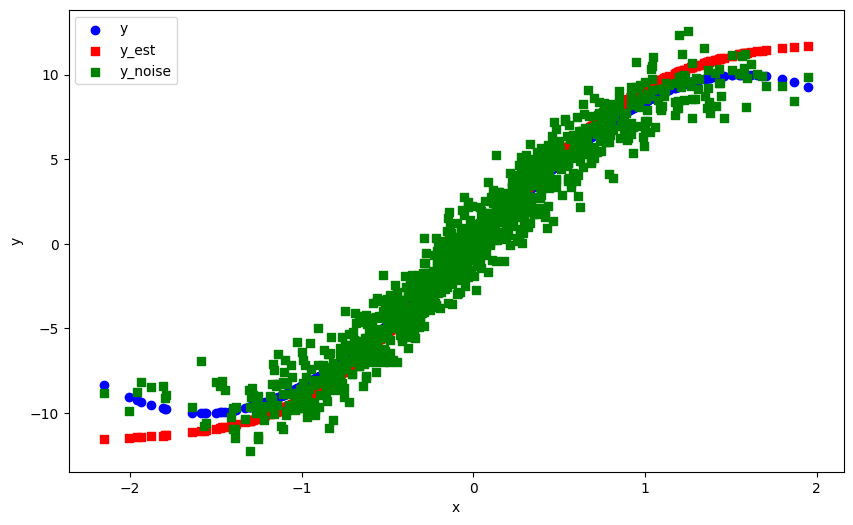

The programm is closed


In [20]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

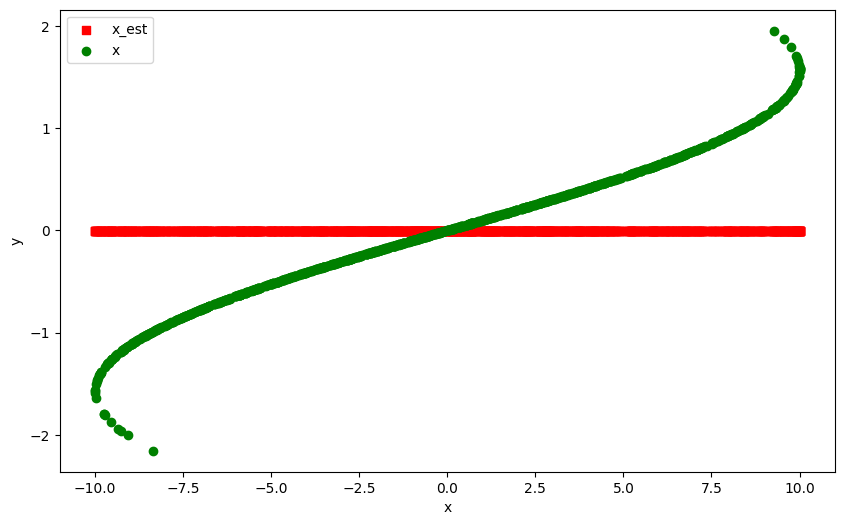

The programm is closed


In [21]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")